# BPTT (backpropagation through time)

## モデルの定義

ライブラリの読み込み．

In [1]:
using Base: @kwdef
using Parameters: @unpack # or using UnPack
using Random, ProgressMeter, PyPlot

In [2]:
f(x) = tanh(x)
df(x) = 1 - tanh(x)^2;

In [3]:
@kwdef struct RNNParameter{FT}
    dt::FT = 1 # time step (ms)
    τ::FT = 10 # time constant (ms)
    α::FT = dt / τ 
    η::FT = 1e-2 # learning rate
end

`w_in`は入力層から再帰層への重み，`w_rec`は再帰重み，`w_out`は出力重みである．

In [4]:
@kwdef mutable struct RNN{FT}
    param::RNNParameter = RNNParameter{FT}()
    
    n_batch::UInt32 # batch size
    n_in::UInt32 # number of input units
    n_rec::UInt32 # number of recurrent units
    n_out::UInt32 # number of output units
    
    h0::Array{FT} = zeros(n_batch, n_rec) # initial state of recurrent units

    # weights
    w_in::Array{FT} = 0.1*(rand(n_in, n_rec) .- 1)
    w_rec::Array{FT} = 1.5*randn(n_rec, n_rec)/sqrt(n_rec)
    w_out::Array{FT} = 0.1*(2*rand(n_rec, n_out) .- 1)/sqrt(n_rec)
    bias::Array{FT} = zeros(1, n_rec)
    
    # changes to weights
    dw_in::Array{FT} = zero(w_in)
    dw_rec::Array{FT} = zero(w_rec)
    dw_out::Array{FT} = zero(w_out)
    dbias::Array{FT} = zero(bias)
end

## 7.9.2 更新関数の定義

In [5]:
function update!(variable::RNN, param::RNNParameter, x::Array, y::Array, training::Bool)
    @unpack n_batch, n_in, n_rec, n_out, h0, w_in, w_rec, w_out, bias, dw_in, dw_rec, dw_out, dbias = variable 
    @unpack dt, τ, α, η = param

    t_max = size(x)[2]  # number of timesteps
    u, h = zeros(n_batch, t_max, n_rec), zeros(n_batch, t_max, n_rec) # input (feedforward + recurrent), time-dependent RNN activity vector
    h[:, 1, :] = h0  # initial state

    ŷ = zeros(n_batch, t_max, n_out)  # RNN output
    error = zeros(n_batch, t_max, n_out)  # readout error

    for t in 1:t_max-1
        u[:, t+1, :] = h[:, t, :] * w_rec + x[:, t+1, :] * w_in .+ bias
        h[:, t+1, :] = h[:, t, :] + α * (-h[:, t, :] + f.(u[:, t+1, :]))
        ŷ[:, t+1, :] = h[:, t+1, :] * w_out 
        error[:, t+1, :] = y[:, t+1, :] - ŷ[:, t+1, :]  # readout error
    end
    
    
    # backward
    if training 
        z = zero(h)
        z[:, end, :] = error[:, end, :] * w_out' 

        for t in t_max:-1:1
            zu = z[:, t, :] .* df.(u[:, t, :])
            if t ≥ 2
                z[:, t-1, :] = z[:, t, :] * (1 - α) + error[:, t, :] * w_out' + zu * w_rec * α
                dw_rec[:, :] += h[:, t-1, :]' * zu
            end

            # Updates  Δweights:
            dw_out[:, :] += h[:, t, :]' * error[:, t, :]
            dw_in[:, :]  += x[:, t, :]' * zu
            dbias[:, :] .+= sum(zu)
        end
        
        # update weights
        w_out[:, :] += η / t_max * dw_out
        w_rec[:, :] += η / t_max * α * dw_rec
        w_in[:, :]  += η / t_max * α * dw_in
        bias[:, :]  += η / t_max * α * dbias
        
        # reset
        dw_in[:, :]  = zero(w_in)
        dw_rec[:, :] = zero(w_rec)
        dw_out[:, :] = zero(w_out)
        dbias[:, :]  = zero(bias)
    end

    return error, ŷ, h
end

update! (generic function with 1 method)

## 正弦波の学習
例として正弦波を出力するRNNを考える．入力1,中間64, 出力2のRNNである．

In [6]:
nt = 100  # number of timesteps in one period
n_batch = 1 # batch size
n_in = 1 # number of inputs
n_out = 2 # number of outputs

begin_input = 0 # begin time steps of input
end_input = 30  # end time steps of input

tsteps = 0:nt-1　# array of time steps
x = ones(n_batch) * (begin_input .≤ tsteps .≤ end_input)'  # input array

y = zeros(n_batch, nt, n_out) # target array
y[:, begin_input+1:end, 1] = sin.(tsteps[1:end-begin_input]*0.1)
y[:, begin_input+1:end, 2] = sin.(tsteps[1:end-begin_input]*0.2)

n_epoch = 25000 # number of epoch
error_arr = zeros(Float32, n_epoch); # memory array of each epoch error

入力と訓練データの確認をする．

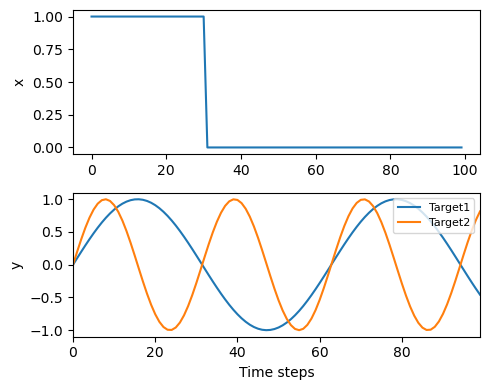

In [8]:
figure(figsize=(5, 4))
subplot(2,1,1); plot(x[1, :]); ylabel("x")
subplot(2,1,2); plot(tsteps, y[1, :, 1], label="Target1"); plot(tsteps, y[1, :, 2], label="Target2")
xlabel("Time steps"); ylabel("y"); xlim(0, tsteps[end])
legend(loc="upper right", fontsize=8)
tight_layout()

モデルの定義をする．

In [9]:
rnn = RNN{Float32}(n_batch=n_batch, n_in=n_in, n_rec=32, n_out=n_out);

学習を実行する．

In [11]:
@showprogress "Training..." for e in 1:n_epoch
    error, ŷ, h = update!(rnn, rnn.param, x, y, true)
    error_arr[e] = sum(error .^ 2)
end

Training...100%|████████████████████████████████████████| Time: 0:01:30


損失の推移を確認する．

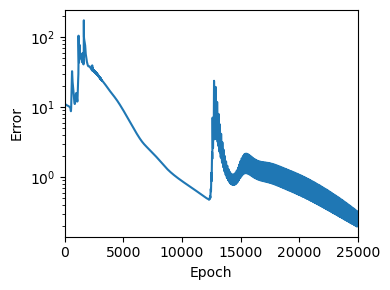

In [12]:
figure(figsize=(4,3))
semilogy(error_arr); ylabel("Error"); xlabel("Epoch"); xlim(0, n_epoch)
tight_layout()

## 学習後の出力の確認

In [13]:
error, ŷ, h = update!(rnn, rnn.param, x, y, false)
println("Error : ", sum(error.^2))

Error : 0.24463312114125013


見やすいように出力のピークに応じて中間層のユニットをソートする．

In [14]:
max_idx = Tuple.(argmax(h[1, :, :]', dims=2))
h_ = h[1, :, sortperm(last.(max_idx)[:, 1])];

出力層，中間層の出力を描画する．

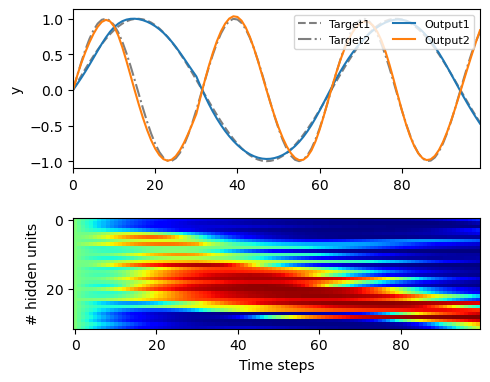

In [15]:
figure(figsize=(5, 4))
subplot(2,1,1)
plot(tsteps, y[1, :, 1], "--k", alpha=.5, label="Target1")
plot(tsteps, y[1, :, 2], "-.k", alpha=.5, label="Target2")
plot(tsteps, ŷ[1, :, 1], label="Output1")
plot(tsteps, ŷ[1, :, 2], label="Output2")
ylabel("y"); xlim(0, tsteps[end])
legend(loc="upper right", ncol=2, fontsize=8)

subplot(2,1,2)
imshow(h_', cmap="jet", aspect=0.85)
xlabel("Time steps"); ylabel("# hidden units")

tight_layout()